In [1]:
import os
import numpy as np
import clip
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from finematch_dataset import FineMatchDataset 
from utils import FastDataLoader 


# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)


# File paths
jsonl_file = "data_labels/FineMatch_test.jsonl"  # Replace with the path to your processed JSONL file
image_folder = "D:/finematch/images/FineMatch"  # Replace with the path to your image folder


# Create the dataset
dataset = FineMatchDataset(jsonl_file, image_folder, transform=preprocess)

# Create the dataloader
dataloader = FastDataLoader(dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# To store all similarities
all_similarities = []
all_targets = []
all_labels_type = []
all_similarity_diff = []
    
for images, queries, labels, labels_type,targets in dataloader:
    image_inputs = images.to(device)  # Image batch
    text_inputs = clip.tokenize(labels).to(device)  # Text inputs
    targets = targets.to(device,dtype=torch.float)  # Target indices
    
    with torch.no_grad():
    
        # Extract embeddings
        image_features = model.encode_image(image_inputs)
        text_features = model.encode_text(text_inputs)

        # Normalize embeddings
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    
    # Compute similarity as cosine similarity
    similarity = (image_features * text_features).sum(dim=-1).cpu().numpy()

    # Compute similarity difference for pairs: (1,2) and (3,4) in the batch
    for i in range(0, len(similarity), 2):  # Increment by 2 to process pairs
        similarity_diff = np.abs(similarity[i] - similarity[i + 1])  # Compute absolute similarity difference between pairs
        all_similarity_diff.append(similarity_diff)
       
    # # Normalize the similarity vector to range [0, 1]
    # similarity_min = similarity.min(dim=-1, keepdim=True)[0]
    # similarity_max = similarity.max(dim=-1, keepdim=True)[0]
    # similarity = (similarity - similarity_min) / (similarity_max - similarity_min + 1e-8)

    

    # Append similarities
    all_similarities.append(similarity)

    # Append targets
    all_targets.append(targets.cpu().numpy())
    # Append labels type
    all_labels_type.append(labels_type)
    

# Concatenate all similarities
all_similarities = np.concatenate(all_similarities, axis=0)
all_targets = np.concatenate(all_targets, axis=0)
all_labels_type = np.concatenate(all_labels_type, axis=0)
all_similarity_diff = np.array(all_similarity_diff)

['Attributes', 'Numbers', 'Entities', 'Relations']


In [8]:
print(all_similarities.shape)
print(all_targets.shape)
print(all_labels_type.shape)
print(all_similarity_diff.shape)

(5684,)
(5684,)
(5684,)
(2842,)


In [9]:
print(all_similarities.dtype)
print(all_targets.dtype)
print(all_labels_type.dtype)

float16
float32
<U8


In [10]:
print(np.unique(all_labels_type))

['Entities']


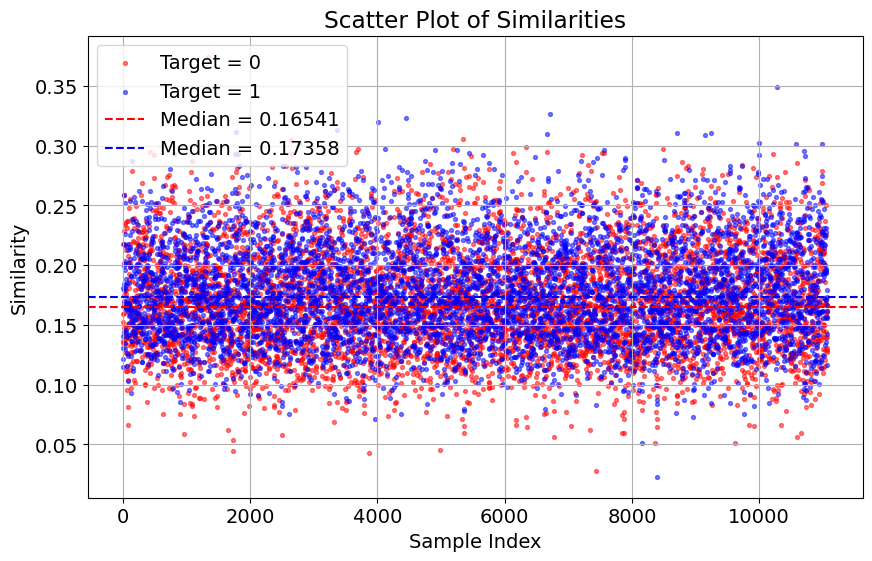

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})

# Calculate the median similarity for target=0 and target=1
median_target_0 = np.median(all_similarities[all_targets == 0])
median_target_1 = np.median(all_similarities[all_targets == 1])

# Scatter plot: target=0 (red), target=1 (blue)
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(all_similarities))[all_targets == 0], all_similarities[all_targets == 0], c='red', label='Target = 0', s=8, alpha=0.5)
plt.scatter(np.arange(len(all_similarities))[all_targets == 1], all_similarities[all_targets == 1], c='blue', label='Target = 1', s=8, alpha=0.5)

# Add median lines for both targets
plt.axhline(median_target_0, color='red', linestyle='--', label=f'Median = {median_target_0:.5f}')
plt.axhline(median_target_1, color='blue', linestyle='--', label=f'Median = {median_target_1:.5f}')

# Add labels and legend
plt.xlabel('Sample Index')
plt.ylabel('Similarity')
plt.title('Scatter Plot of Similarities')
plt.legend()
plt.grid(True)
plt.show()


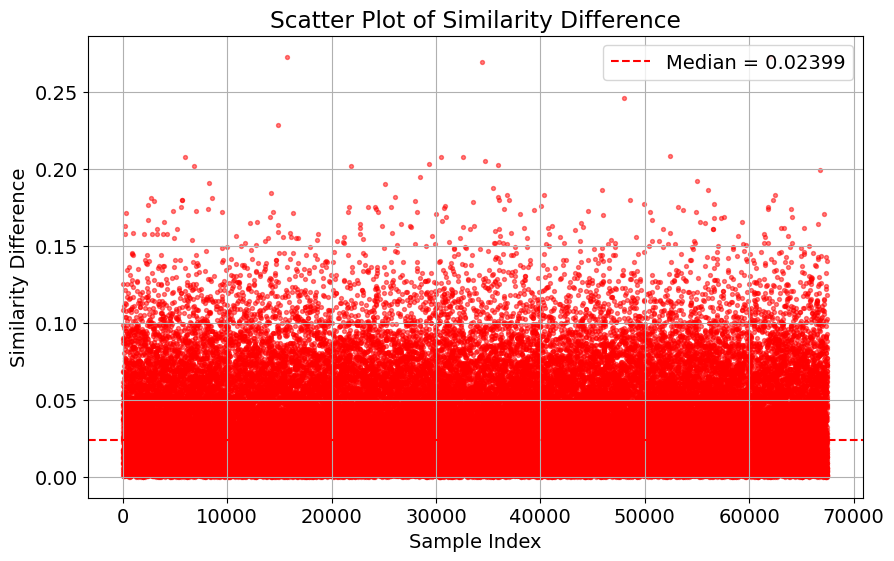

In [39]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})

# Scatter plot: target=0 (red), target=1 (blue)
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(all_similarity_diff)), all_similarity_diff,c='red',s=8, alpha=0.5)

median = np.median(all_similarity_diff)
plt.axhline(median, color='red', linestyle='--', label=f'Median = {median:.5f}')


# Add labels and legend
plt.xlabel('Sample Index')
plt.ylabel('Similarity Difference')
plt.title('Scatter Plot of Similarity Difference')
plt.legend()
plt.grid(True)
plt.show()


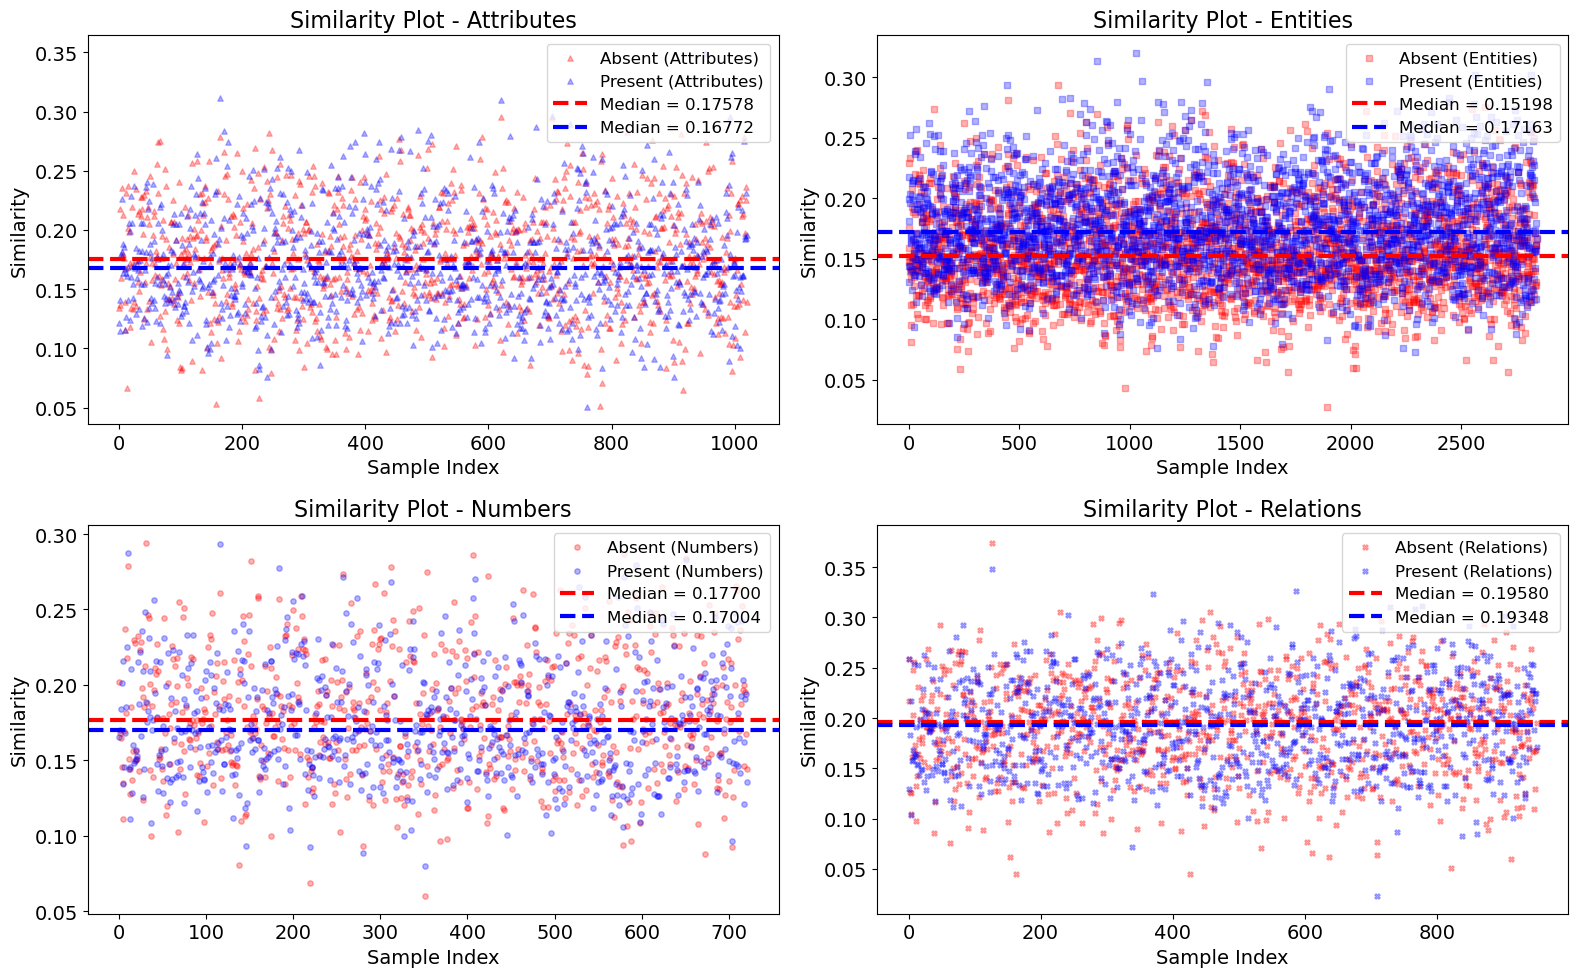

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define target value labels
target_value_labels = {0: "Absent", 1: "Present"}

# Define marker styles for different label types
markers = {
    'Numbers': 'o',  # Circle for label_type_1
    'Attributes': '^',  # Triangle for label_type_2
    'Entities': 's',  # Square for label_type_3
    'Relations': 'X',  # X for label_type_4
    # Add more label types and markers as needed
}

# Create a figure with 4 subplots (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.flatten()  # Flatten the 2D array to make indexing easier

# Iterate over the unique label types and plot each on a separate subplot
for idx, label_type in enumerate(np.unique(all_labels_type)):
    ax = axs[idx]  # Get the axis for the current subplot
    
    # Get the indices for the current label type
    indices = (all_labels_type == label_type)
    
    # Get the target values for these indices (0 or 1)
    target_values = all_targets[indices]
    
    # Initialize empty lists for the target-specific similarity values
    similarities_target_0 = []
    similarities_target_1 = []
    
    # Plot points for target=0 (red) and target=1 (blue) with specific marker for label_type
    for target_value in [0, 1]:
        target_indices = (target_values == target_value)
        
        # Get the similarity values for the current target value
        target_similarities = all_similarities[indices][target_indices]
        
        # Store the similarities for each target value
        if target_value == 0:
            similarities_target_0 = target_similarities
        else:
            similarities_target_1 = target_similarities
        
        # Scatter plot for current target with specific marker for current label_type
        ax.scatter(np.arange(len(target_similarities)), 
                   target_similarities, 
                   c='red' if target_value == 0 else 'blue', 
                   marker=markers.get(label_type, 'o'),  # Default to circle if marker not specified
                   label=f"{target_value_labels[target_value]} ({label_type})",
                   alpha=0.3, s=15)

    # Calculate the median for target=0 and target=1
    median_target_0 = np.median(similarities_target_0) if len(similarities_target_0) > 0 else None
    median_target_1 = np.median(similarities_target_1) if len(similarities_target_1) > 0 else None

    # Draw the median horizontal lines
    if median_target_0 is not None:
        ax.axhline(median_target_0, color='red', linestyle='--', label=f'Median = {median_target_0:.5f}', linewidth=3)
    if median_target_1 is not None:
        ax.axhline(median_target_1, color='blue', linestyle='--', label=f'Median = {median_target_1:.5f}', linewidth=3)

    # Set title and labels for each subplot
    ax.set_title(f"Similarity Plot - {label_type}", fontsize=16)
    ax.set_xlabel('Sample Index', fontsize=14)
    ax.set_ylabel('Similarity', fontsize=14)
    ax.legend(loc="upper right", fontsize=12)

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


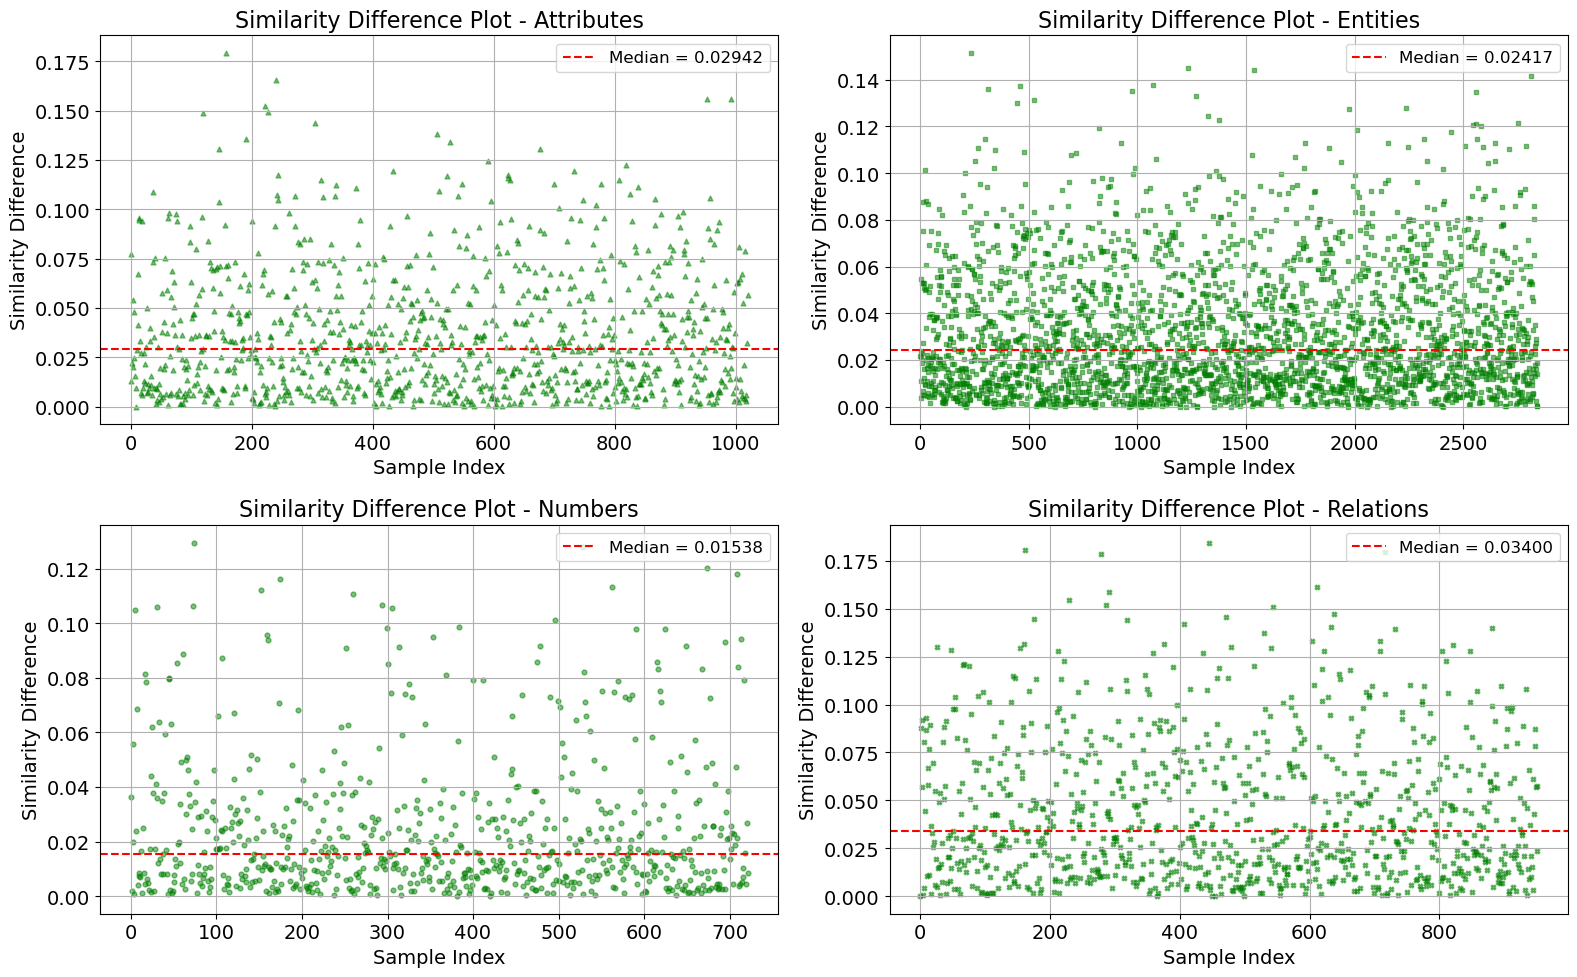

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define marker styles for different label types
markers = {
    'Numbers': 'o',  # Circle for label_type_1
    'Attributes': '^',  # Triangle for label_type_2
    'Entities': 's',  # Square for label_type_3
    'Relations': 'X',  # X for label_type_4
    # Add more label types and markers as needed
}

# Create a figure with 4 subplots (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.flatten()  # Flatten the 2D array to make indexing easier

# Iterate over the unique label types and plot each on a separate subplot
for idx, label_type in enumerate(np.unique(all_labels_type)):
    ax = axs[idx]  # Get the axis for the current subplot
    
    # Get the indices for the current label type and match them with similarity differences
    indices = (all_labels_type == label_type)
    indices = indices[::2]  # Adjust for pairing (every 2nd element)

    # Filter similarity differences based on the indices for the current label type
    similarities_for_label = all_similarity_diff[indices]

    # Scatter plot for current label type
    ax.scatter(np.arange(len(similarities_for_label)), 
               similarities_for_label, 
               c='green', 
               marker=markers.get(label_type, 'o'),  # Default to circle if marker not specified
               alpha=0.5, s=12)

    # Calculate the median for the similarity differences
    median_value = np.median(similarities_for_label)

    # Draw the median horizontal line
    ax.axhline(median_value, color='red', linestyle='--', label=f'Median = {median_value:.5f}')

    # Set title and labels for each subplot
    ax.set_title(f"Similarity Difference Plot - {label_type}", fontsize=16)
    ax.set_xlabel('Sample Index', fontsize=14)
    ax.set_ylabel('Similarity Difference', fontsize=14)
    ax.grid(True)
    ax.legend(loc="upper right", fontsize=12)

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


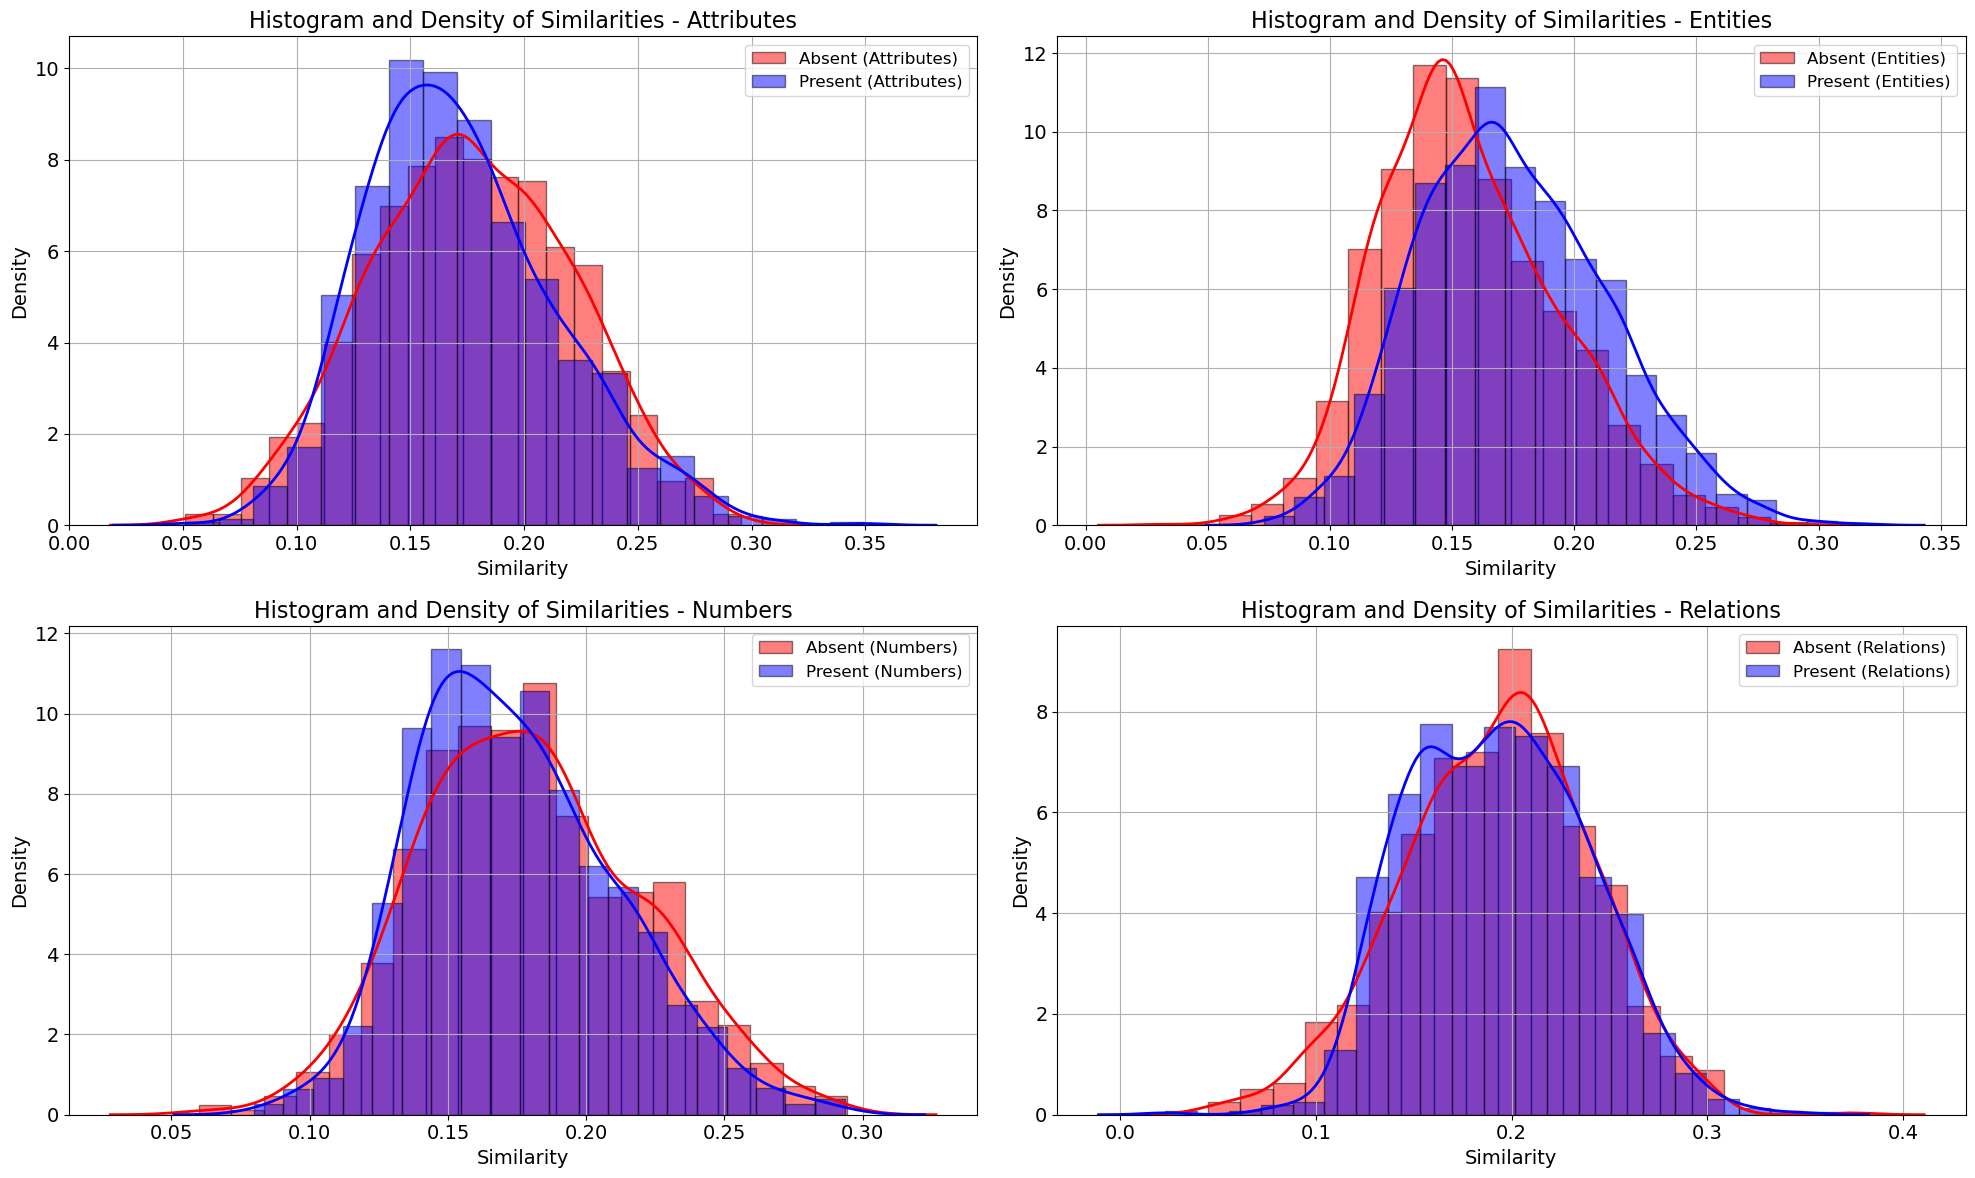

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of bins for the histogram
num_bins = 20

# Define the labels for the target (Absent/Present)
target_value_labels = {0: "Absent", 1: "Present"}

# Create a figure with 4 subplots (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()  # Flatten the 2D array to make indexing easier

# Iterate over the unique label types and plot histograms in separate subplots
for idx, label_type in enumerate(np.unique(all_labels_type)):
    ax = axs[idx]  # Get the axis for the current subplot
    
    # Get the indices for the current label type
    indices = (all_labels_type == label_type)

    # Get the target values for these indices (0 or 1)
    target_values = all_targets[indices]
    similarities_label_type = all_similarities[indices]

    # Plot histograms for target=0 (red) and target=1 (blue)
    for target_value in [0, 1]:
        target_indices = (target_values == target_value)
        color = 'red' if target_value == 0 else 'blue'
        label = f"{target_value_labels[target_value]} ({label_type})"

        # Plot histogram for the current target with density=True to normalize the histogram
        ax.hist(similarities_label_type[target_indices], bins=num_bins, color=color, alpha=0.5,
                label=label, edgecolor='black', density=True)

        # Plot the kernel density estimate (KDE) curve
        sns.kdeplot(similarities_label_type[target_indices], ax=ax, color=color, linewidth=2)

    # Set title and labels for each subplot
    ax.set_title(f"Histogram and Density of Similarities - {label_type}", fontsize=16)
    ax.set_xlabel('Similarity', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.grid(True)
    ax.legend(loc="upper right", fontsize=12)

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


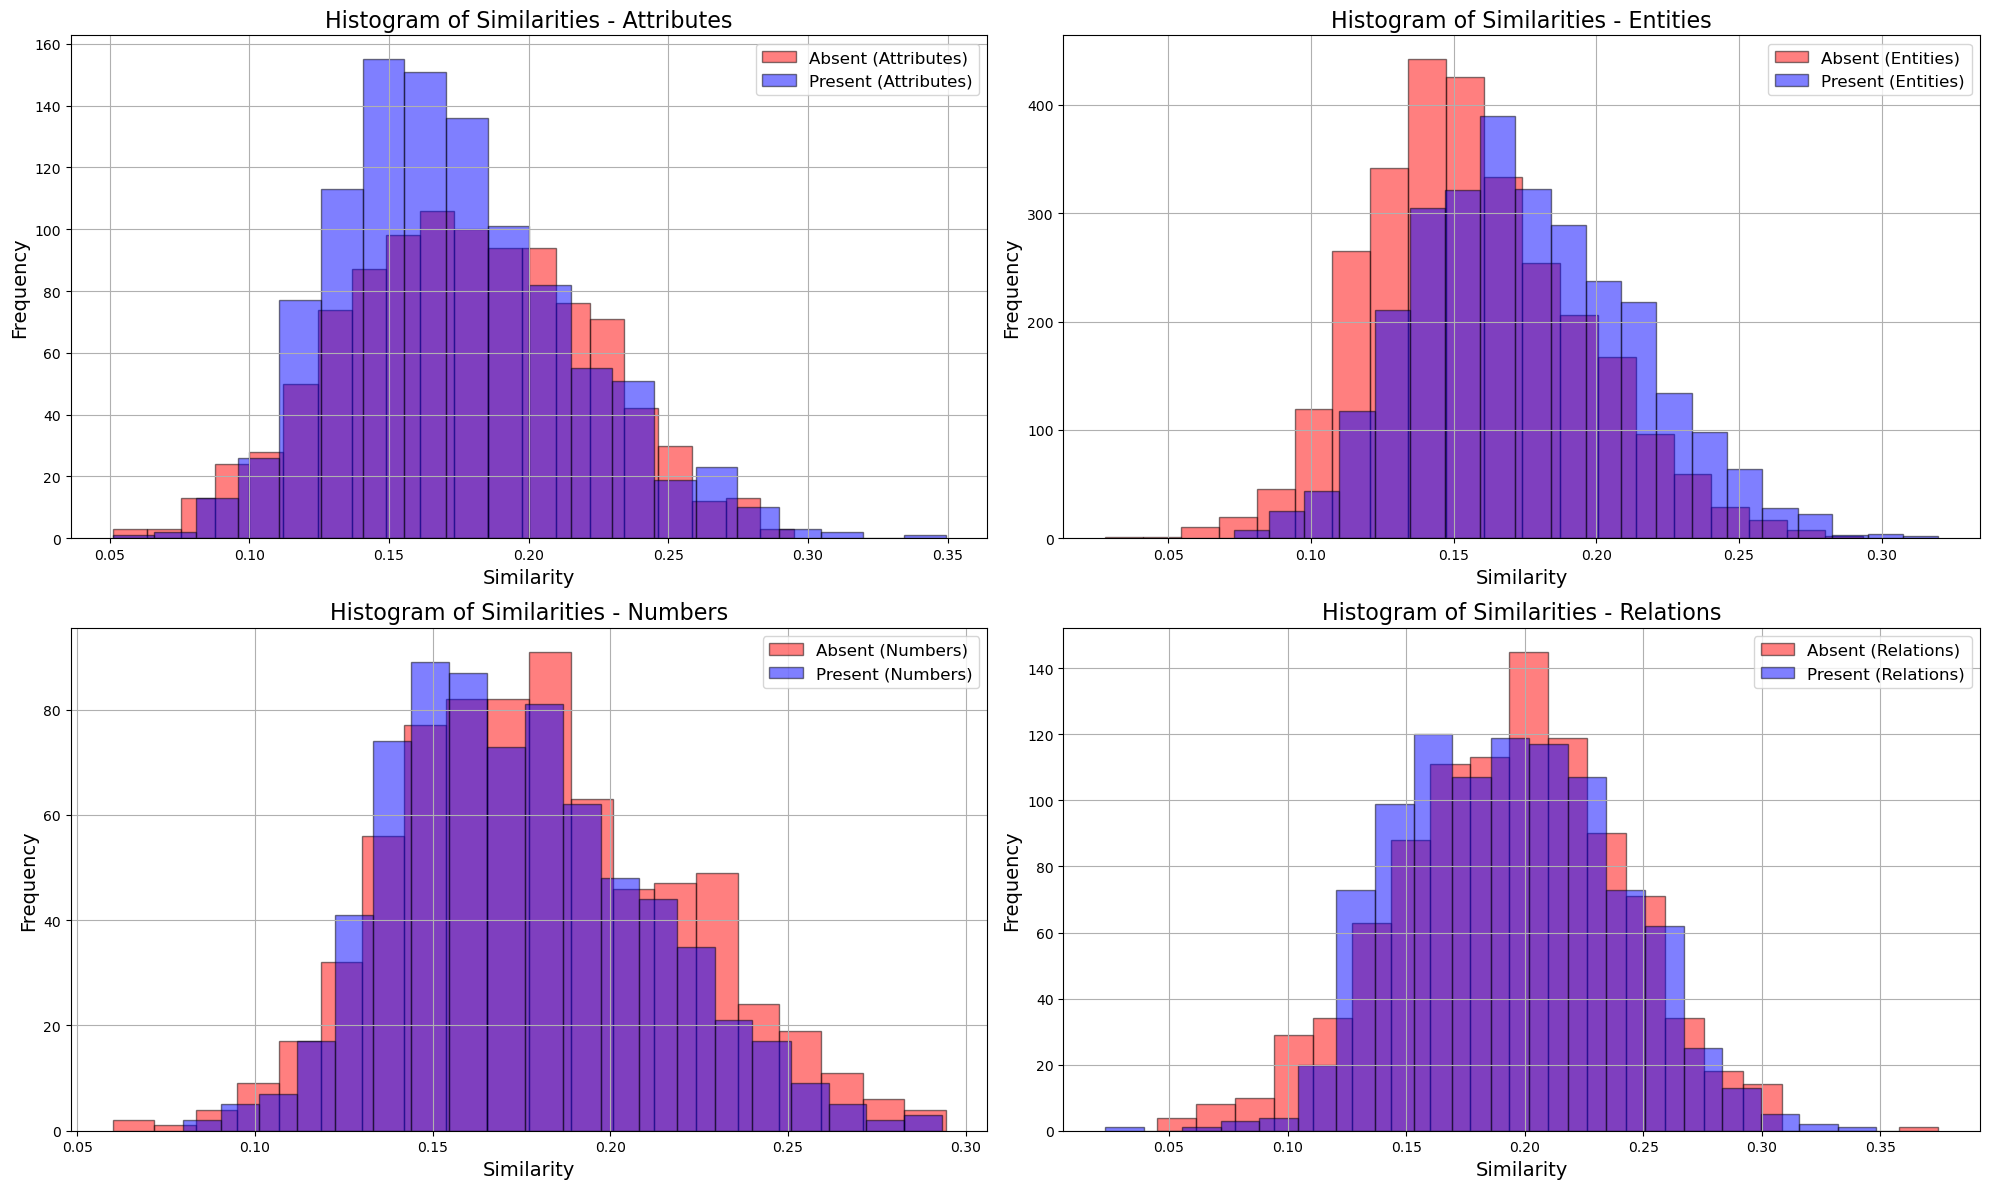

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of bins for the histogram
num_bins = 20

# Define the labels for the target (Absent/Present)
target_value_labels = {0: "Absent", 1: "Present"}

# Create a figure with 4 subplots (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()  # Flatten the 2D array to make indexing easier

# Iterate over the unique label types and plot histograms in separate subplots
for idx, label_type in enumerate(np.unique(all_labels_type)):
    ax = axs[idx]  # Get the axis for the current subplot
    
    # Get the indices for the current label type
    indices = (all_labels_type == label_type)

    # Get the target values for these indices (0 or 1)
    target_values = all_targets[indices]
    similarities_label_type = all_similarities[indices]

    # Plot histograms for target=0 (red) and target=1 (blue)
    for target_value in [0, 1]:
        target_indices = (target_values == target_value)
        color = 'red' if target_value == 0 else 'blue'
        label = f"{target_value_labels[target_value]} ({label_type})"

        # Plot histogram for the current target
        ax.hist(similarities_label_type[target_indices], bins=num_bins, color=color, alpha=0.5,
                label=label, edgecolor='black')

    # Set title and labels for each subplot
    ax.set_title(f"Histogram of Similarities - {label_type}", fontsize=16)
    ax.set_xlabel('Similarity', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.grid(True)
    ax.legend(loc="upper right", fontsize=12)

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show() 